## Tutorial: Multi-Energy refinement

It is often advantageous to refine reflectivity measured at multiple photon energies simultaneously in order to determine a unique model. The intrinsic contrast afforded at resonance allows for simple global fits for improved model uniqueness. This tutorial will present a suitable method to simultaneously refine datasets taken across multiple energies on a single sample.

### Initialize PyPXR
We begin by initializing the same modules for fitting polarized reflectivity as stated in the first tutorial. 
The only new function required is `GlobalObjective` that will allow for simultaneous model refinement

In [1]:
%matplotlib inline

import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py

sys.path.append("../../../src/PyPXR") # Temporary solution until hosted on pip

from reflectivity import *
from structure import *

# For Fitting
from refnx.dataset import ReflectDataset # Object used to define data
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective

PyPXR provides two datasets for this example measured on the same sample

In [2]:
mypath = "../../../src/PyPXR/example_data/"
# Energy 1
data_spol_en1 = os.path.join(mypath, 'Feb19_Exp101_p100.txt')  # s-pol data
data_ppol_en1 = os.path.join(mypath, 'Feb19_Exp101_p190.txt')  # p-pol data
mydata_s1 = np.genfromtxt(data_spol_en1, delimiter='\t')
mydata_p1 = np.genfromtxt(data_ppol_en1, delimiter='\t')

# Energy 2
data_spol_en2 = os.path.join(mypath, 'Feb19_Exp102_p100.txt')  # s-pol data
data_ppol_en2 = os.path.join(mypath, 'Feb19_Exp102_p190.txt')  # p-pol data
mydata_s2 = np.genfromtxt(data_spol_en2, delimiter='\t')
mydata_p2 = np.genfromtxt(data_ppol_en2, delimiter='\t')

# Concatenate spol / ppol data together for fitting
mydata_en1 = np.concatenate([mydata_s1, mydata_p1])
mydata_en2 = np.concatenate([mydata_s2, mydata_p2])

# Construct objects to use refnx fitting modules, a Transpose is called to set the axis correctly
data_en1 = ReflectDataset(mydata_en1.T)
data_en2 = ReflectDataset(mydata_en2.T)


To initiate multi-energy model refinement we will utilize a combination of two strategies:

1) Shared `PXR_Slab` objects that are identical between data-sets. Properties can be determined through an input energy.

2) A series of inter-slab constraints that allow us to ensure identical structural parameters (thickness, roughness, etc.)

### Create models for each dataset.

In [3]:
# List of energies associated with each dataset
# en1 = 284.7 eV
# en2 = 285.7 ev
en_list = [284.7, 285.7] #[eV]

# Substrate / Superstrate objects
si = PXR_MaterialSLD('Si', density=2.33, name='Si') #Substrate
sio2 = PXR_MaterialSLD('SiO2', density=2.28, name='SiO2') #Substrate
vacuum = PXR_MaterialSLD('', density=1, name='vacuum') #Superstrate

# Slabs for each material
si_slab = si(0, 0.5) #thickness of bounding substrate does not matter
sio2_slab = sio2(12, 1)

We did not specify a photon energy for these items. When we call `PXR_ReflectModel` later it will update based on the input energy. This allows us to use a single slab object for both structures.

In [4]:
# Energy 1
# Bulk object
n_xx1 = complex(-0.00043, 0.0001) # [unitless] #Ordinary Axis
n_zz1 = complex(-0.00049, 0.00019) # [unitless] #Extraordinary Axis
posa_en1 = PXR_SLD(np.array([n_xx1, n_zz1]), name='posa1') #Molecule
# Surface objet
n_xx1 = complex(-0.00019, 0.00152) # [unitless] #Ordinary Axis
n_zz1 = complex(-0.00020, 0.0000) # [unitless] #Extraordinary Axis
posa_surface_en1 = PXR_SLD(np.array([n_xx1, n_zz1]), name='posa1_surf') #Molecule

posa_slab_en1 = posa_en1(711, 1) # Bulk Slab
posa_surface_slab_en1 = posa_surface_en1(20,1) # Surface Slab

# Energy 2
# Bulk object
n_xx2 = complex(0.00103, 0.00169) # [unitless] #Ordinary Axis
n_zz2 = complex(0.00103, 0.00061) # [unitless] #Extraordinary Axis
posa_en2 = PXR_SLD(np.array([n_xx2, n_zz2]), name='posa2') #Molecule
# Surface objet
n_xx2 = complex(0.00063, 0.0007) # [unitless] #Ordinary Axis
n_zz2 = complex(0.00077, 0.00038) # [unitless] #Extraordinary Axis
posa_surface_en2 = PXR_SLD(np.array([n_xx2, n_zz2]), name='posa2_surf') #Molecule

posa_slab_en2 = posa_en2(711, 1) # Bulk Slab
posa_surface_slab_en2 = posa_surface_en2(20,1) # Surface Slab

In [5]:
# Structures for each energy

structure_en1 = vacuum | posa_surface_slab_en1 | posa_slab_en1 | sio2_slab | si_slab
structure_en2 = vacuum | posa_surface_slab_en2 | posa_slab_en2 | sio2_slab | si_slab

When making `PXR_ReflectModel` objects, be sure to specify what energy corresponds to each object. This will be important when calling the optical constants of each `PXR_MaterialSLD` object.

In [6]:
# Models
model_en1 = PXR_ReflectModel(structure_en1, energy=en_list[0], pol='sp')
model_en2 = PXR_ReflectModel(structure_en2, energy=en_list[1], pol='sp')

obj_en1 = Objective(model_en1, data_en1, transform=Transform('logY'))
obj_en2 = Objective(model_en2, data_en2, transform=Transform('logY'))

A `GlobalObjective` is used in order to simultaneously refine both datasets

In [7]:
objective = GlobalObjective([obj_en1, obj_en2]) 

### Enforce inter-energy constraints

In [8]:
# Substrate parameters are shared between structures and do not need to be constrained.
si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=False, bounds=(1,2))

sio2_slab.thick.setp(vary=False, bounds=(5,20))
sio2_slab.rough.setp(vary=True, bounds=(2,10))
sio2_slab.sld.density.setp(vary=False)

# The default tensor symmetry is for uniaxial materials.
# This automatically sets constraints for xx = yy and ixx = iyy
posa_slab_en1.thick.setp(vary=True, bounds=(400,900))
posa_slab_en1.rough.setp(vary=True, bounds=(0.2,20))
posa_slab_en1.sld.xx.setp(vary=True, bounds=(-0.00001, -0.01))
posa_slab_en1.sld.zz.setp(vary=True, bounds=(-0.00001, -0.01))
posa_slab_en1.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_slab_en1.sld.izz.setp(vary=True, bounds=(0, 0.01))

posa_surface_slab_en1.thick.setp(vary=True, bounds=(5,30))
posa_surface_slab_en1.rough.setp(vary=True, bounds=(0.5,20))
posa_surface_slab_en1.sld.xx.setp(vary=True, bounds=(-0.00001, -0.01))
posa_surface_slab_en1.sld.zz.setp(vary=True, bounds=(-0.00001, -0.01))
posa_surface_slab_en1.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_surface_slab_en1.sld.izz.setp(vary=True, bounds=(0, 0.01))

# The default tensor symmetry is for uniaxial materials.
# This automatically sets constraints for xx = yy and ixx = iyy
posa_slab_en2.thick.setp(vary=None, constraint=posa_slab_en1.thick)
posa_slab_en2.rough.setp(vary=None, constraint=posa_slab_en1.rough)
#posa_slab_en2.thick.setp(vary=True, bounds=(400,900))
#posa_slab_en2.rough.setp(vary=True, bounds=(0.2,20))
posa_slab_en2.sld.xx.setp(vary=True, bounds=(-0.01, 0.01))
posa_slab_en2.sld.zz.setp(vary=True, bounds=(-0.01, 0.01))
posa_slab_en2.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_slab_en2.sld.izz.setp(vary=True, bounds=(0, 0.01))

posa_surface_slab_en2.thick.setp(vary=None, constraint=posa_surface_slab_en1.thick)
posa_surface_slab_en2.rough.setp(vary=None, constraint=posa_surface_slab_en1.rough)
#posa_surface_slab_en2.thick.setp(vary=True, bounds=(5,30))
#posa_surface_slab_en2.rough.setp(vary=True, bounds=(0.2,20))
posa_surface_slab_en2.sld.xx.setp(vary=True, bounds=(-0.01, 0.01))
posa_surface_slab_en2.sld.zz.setp(vary=True, bounds=(-0.01, 0.01))
posa_surface_slab_en2.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_surface_slab_en2.sld.izz.setp(vary=True, bounds=(0, 0.01))


In [9]:
fitter = CurveFitter(objective, nwalkers=200, pool=4)
# Optionalal change to the initialization. Begin chains near initial conditions
fitter.initialise(pos='jitter')

In [10]:
chain = fitter.sample(20000, random_state=246681) # seed random number generator for repeatability
fitter.reset()
chain = fitter.sample(10000, random_state=991166)

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

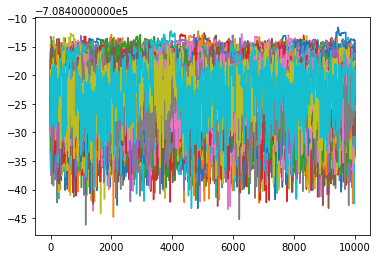

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
lp = fitter.logpost
test = plt.plot(lp)
#plt.yscale('log')

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

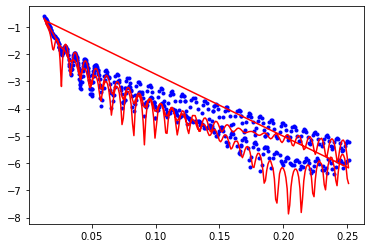

In [45]:
objective.objectives[1].plot()

In [140]:
logpost = fitter.logpost
chainmin_lp = np.max(logpost, axis=0) #Where an individual chain converges
globmin_lp = np.max(logpost) #The current global min
#Look for the positions for the chains to reach a LOCAL MINIMA
for nburn, array in enumerate(logpost): #Cycle through the draws to find the convergence
    converge = np.abs(array - chainmin_lp)/np.abs(chainmin_lp) < 0.005
    numpass = np.sum(converge)
    if numpass/200 > 0.95:
        mask = np.abs(array - globmin_lp)/np.abs(globmin_lp) < 0.005 #Create a mask to remove those outside the global minima
        break
print(nburn)


2465


In [144]:
from refnx.analysis import process_chain
objective_processed = objective
_ = process_chain(objective_processed, fitter.chain[:,mask,:], nburn=2465, nthin=1, flatchain=True)

In [15]:
objective_processed.objectives[1].plot()

NameError: name 'objective_processed' is not defined

In [27]:
print(objective.chisqr()/(610-22))

2427.1613069539935


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

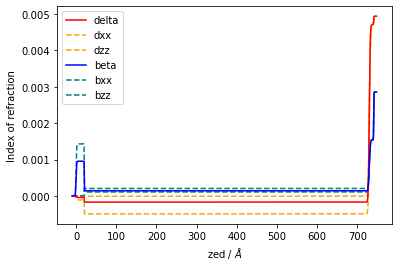

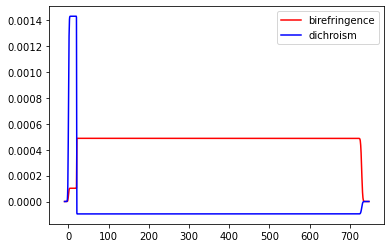

In [20]:
structure_en1.plot(difference=True)

In [21]:
print(objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 1870588781256
Dataset = <None>, 610 points
datapoints = 610
chi2 = 481677.0852687457
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:     'bkg'     , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'dq - resolution', value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'en_offset'  , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
__